# 1 - Extração dos dados

In [15]:
#segunda parte
import pandas as pd

dados = pd.read_csv("telecomx_tratado.csv")

customer_df = pd.json_normalize(dados['customer'].apply(eval))
account_df = pd.json_normalize(dados['account'].apply(eval))

df = pd.concat([dados['Churn'], customer_df, account_df], axis=1)

df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['Charges.Monthly'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce')
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

df.fillna({'tenure':0, 'Charges.Monthly':0, 'Charges.Total':0}, inplace=True)

print(df.head())


  Churn  gender  SeniorCitizen Partner Dependents  tenure        Contract  \
0    No  Female              0     Yes        Yes       9        One year   
1    No    Male              0      No         No       9  Month-to-month   
2   Yes    Male              0      No         No       4  Month-to-month   
3   Yes    Male              1     Yes         No      13  Month-to-month   
4   Yes  Female              1     Yes         No       3  Month-to-month   

  PaperlessBilling     PaymentMethod  Charges.Monthly  Charges.Total  
0              Yes      Mailed check             65.6         593.30  
1               No      Mailed check             59.9         542.40  
2              Yes  Electronic check             73.9         280.85  
3              Yes  Electronic check             98.0        1237.85  
4              Yes      Mailed check             83.9         267.40  


# 2 Análise Exploratória

/tmp/ipython-input-180353376.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='Blues_d', edgecolor=None)


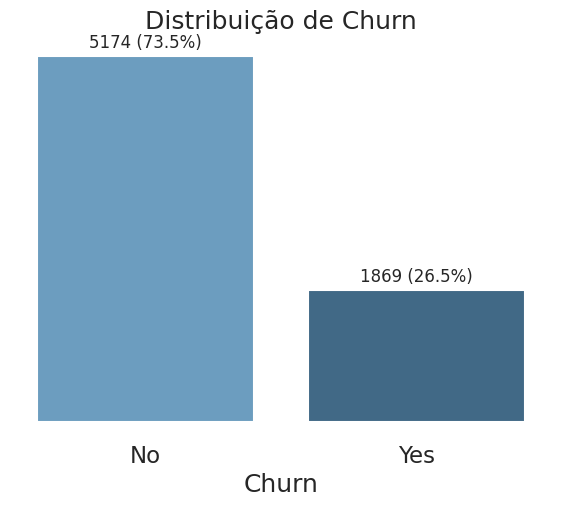

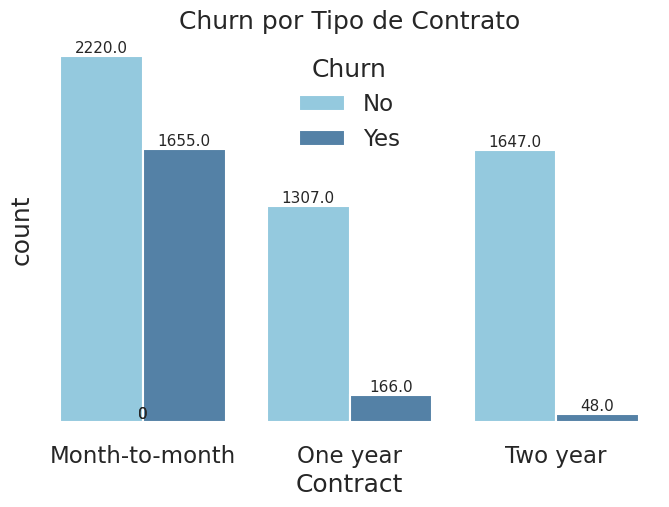

/tmp/ipython-input-180353376.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Charges.Total', palette=['#ADD8E6','#4682B4'], fliersize=2)


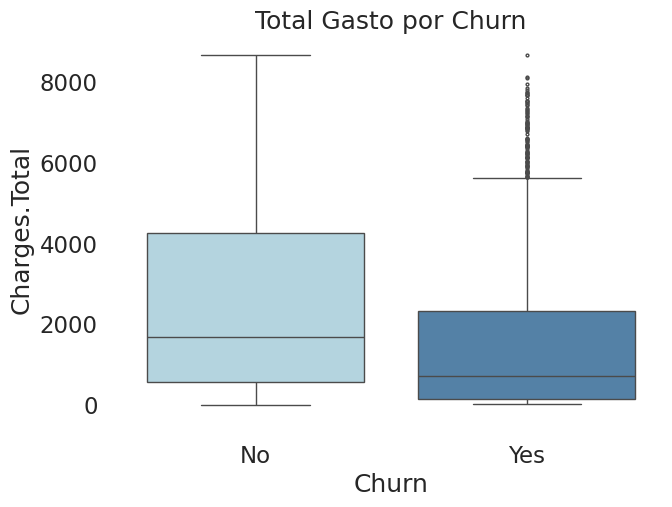

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("talk")

# --------------------------
# Distribuição de Churn
# --------------------------
plt.figure(figsize=(7,5))
churn_counts = df['Churn'].value_counts()
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='Blues_d', edgecolor=None)
sns.despine(left=True, bottom=True)
ax.set_yticks([])

# Valores em cima das barras
total = churn_counts.sum()
for i, val in enumerate(churn_counts.values):
    ax.text(i, val + 50, f'{val} ({val/total:.1%})', ha='center', va='bottom', fontsize=12)

plt.title("Distribuição de Churn")
plt.show()

# --------------------------
# Churn por Contrato
# --------------------------
plt.figure(figsize=(8,5))
contract_churn = df.groupby(['Contract','Churn']).size().reset_index(name='count')
ax = sns.barplot(data=contract_churn, x='Contract', y='count', hue='Churn', palette=['#87CEEB','#4682B4'])
sns.despine(left=True, bottom=True)
ax.set_yticks([])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x()+p.get_width()/2., height), ha='center', va='bottom', fontsize=11)
plt.title("Churn por Tipo de Contrato")
plt.legend(title="Churn")
plt.show()

# --------------------------
# Boxplot de Gastos Totais por Churn
# --------------------------
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Churn', y='Charges.Total', palette=['#ADD8E6','#4682B4'], fliersize=2)
sns.despine(left=True, bottom=True)
plt.title("Total Gasto por Churn")
plt.show()


# Modelagem Preditiva


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Seleção de colunas
X = df[['tenure','Charges.Monthly','Charges.Total','SeniorCitizen']]
y = df['Churn']

# Transformar target em números
le = LabelEncoder()
y = le.fit_transform(y)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento (opcional)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Matriz de Confusão:
 [[898 107  32]
 [199 165   8]
 [ 33  12   0]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1037
           1       0.58      0.44      0.50       372
           2       0.00      0.00      0.00        45

    accuracy                           0.73      1454
   macro avg       0.46      0.44      0.44      1454
weighted avg       0.72      0.73      0.72      1454



# Relatório Final - Segunda Parte

Objetivo:
Prever clientes com maior risco de evasão (Churn) usando modelos preditivos.

Processo ETL:
- Extração dos dados tratados da Parte 1.
- Normalização de colunas aninhadas.
- Conversão de colunas numéricas e tratamento de valores nulos.

Análise Exploratória:
- Distribuição de Churn e comparação por tipo de contrato.
- Boxplot de gastos totais por Churn.

Modelagem Preditiva:
- Modelo Random Forest treinado para prever Churn.
- Avaliação com matriz de confusão e relatório de métricas.

Conclusões:
- Variáveis mais importantes: tenure, Charges.Total, Charges.Monthly, SeniorCitizen.
- Estratégia: focar retenção em clientes de alto risco identificados pelo modelo.